# Figure 5: Gene-level 5hmC analysis

This notebook analyses 5hmC at a gene-level to identify which genes have high levels of 5hmC. To do this, the sample CpG sites are grouped by gene and gene feature. An average ratio of 5hmCpG per CpG (5hmC level) is calculated for each gene and feature, and then a genome-wide average is calculated from that. 

We then calculate an enrichment score for each gene and feature, which is the log2 fold-ratio of the gene/feature's 5hmC level to the genome-wide (genic) average. Sorting by score, we then compare methods using Spearman's rank correlation coefficient. In this case, the null-hypothesis is that the two sets of enrichment scores are unrelated (i.e., that nanopore hydroxymethylation is completely unrelated to TAB hydroxymethylation at the gene level). The alternative hypothesis is that the two sets of scores are related. The higher the Spearman statistic, the more closely related the score sets are. 

We then wanted to see where is 5hmC most prominent within those, and other, genes. We started this looking at the promoter region relative to the gene body. 

The null hypothesis is that 5hmC is randomly scattered within genes, in which case each feature will have the same mean 5hmC level. The alternative hypothesis is that 5hmC is concentrated in a given feature or in blocks, in which case some features/blocks will more CpG hydroxymethylation than others. 

In [1]:
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth
import pandas as pd

dry = True

if dry == True:
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_stranded_sub.bed'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    del nano_mc_df
    tab_df = pd.read_csv(tab_bed_path, sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth", "strand"])

else:
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_stranded.bed'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    del nano_mc_df
    tab_df = pd.read_csv(tab_bed_path, sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth", "strand"])


In [8]:
nano_hmc_df

,chromosome,chromStart,chromEnd,strand,modification_type,readCount,percentMeth,method,Chromosome,Start,End,Strand
0,chr1,3050094,3050095,+,5hmC,20,0.00,Nanopore 5hmC,chr1,3050094,3050095,+
1,chr1,3050095,3050096,-,5hmC,22,0.00,Nanopore 5hmC,chr1,3050095,3050096,-
3,chr1,3050195,3050196,-,5hmC,25,0.00,Nanopore 5hmC,chr1,3050195,3050196,-
5,chr1,3050223,3050224,-,5hmC,24,0.00,Nanopore 5hmC,chr1,3050223,3050224,-
7,chr1,3050262,3050263,-,5hmC,24,0.00,Nanopore 5hmC,chr1,3050262,3050263,-
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,chr1,72612390,72612391,-,5hmC,11,18.18,Nanopore 5hmC,chr1,72612390,72612391,-
999996,chr1,72612451,72612452,+,5hmC,12,0.00,Nanopore 5hmC,chr1,72612451,72612452,+
999997,chr1,72612452,72612453,-,5hmC,12,33.33,Nanopore 5hmC,chr1,72612452,72612453,-
999998,chr1,72612586,72612587,+,5hmC,10,0.00,Nanopore 5hmC,chr1,72612586,72612587,+


In [6]:
import pyranges as pr
import numpy as np

def addStrandsToTAB(tab_pr):
    stranded_tab_bed = pr.read_bed('./data/TAB_data/CRR008807_TAB_cytosine_report.tsv.CpG_report_strands.zero.bed')
    return tab_pr.join(stranded_tab_bed).drop(["Start_b", "End_b"])

def makePyrange(df):
    if "strand" in df.columns:
        df["Chromosome"], df["Start"], df["End"], df["Strand"] = df["chromosome"], df["chromStart"], df["chromEnd"], df["strand"]
        df = df[["Chromosome", "Start", "End", "Strand", "percentMeth"]]
        return  pr.PyRanges(df)
    else: 
        df["Chromosome"], df["Start"], df["End"] = df["chromosome"], df["chromStart"], df["chromEnd"]
        df = df[["Chromosome", "Start", "End", "percentMeth"]]
        return  addStrandsToTAB(pr.PyRanges(df))
    
def intersectGenes(pyrange):
    gene_bed = pr.read_bed('./feature_references/revised/merged/GENCODE_Basic_mm39_Genes_merged.bed')
    return pyrange.join(gene_bed, 
                        strandedness="same", 
                        suffix="_gene").drop(["ItemRGB", "BlockCount", "BlockSizes", "Score", "ThickEnd", "ThickStart", "BlockStarts"])

def groupGenesMakeDF(pyrange):
    genic_means = pyrange.as_df().groupby(["Name"])["percentMeth"].mean().reset_index()
    return genic_means

def log2FromMean(mean_df):
    mean = mean_df["percentMeth"].mean()
    
    with np.errstate(divide="ignore"):
        mean_df["log2FromMean"] = np.log2(
            np.divide(mean_df["percentMeth"], mean)
        )

    return mean_df.replace(-np.inf, np.nan)

def ax1MethodWrapper(df):
    pyrange = makePyrange(df)
    pr_with_genes = intersectGenes(pyrange)
    grouped_by_gene = groupGenesMakeDF(pr_with_genes)
    grouped_by_gene = log2FromMean(grouped_by_gene)
    return grouped_by_gene

def ax1Main():
    grouped_nano_df = ax1MethodWrapper(nano_hmc_df)
    grouped_tab_df = ax1MethodWrapper(tab_df)
    merged_df = pd.merge(grouped_nano_df, grouped_tab_df, "inner", ["Name"], suffixes=["_Nanopore", "_TAB"])
    return merged_df

def makeRefPyrange():
    def readPromoterFiles():
          
        promoters_bed = pr.read_bed('./feature_references/promoters/mm39_ensembl_promoters_modified.bed')
        gene_names = pr.read_bed('./feature_references/promoters/mm39_mouse_epdnew_ENS.bed')

        named_promoters = promoters_bed.join(gene_names, apply_strand_suffix=False)
        named_promoters = named_promoters.drop(["Start_b", "End_b", "Score_b"])
        named_promoters_df = named_promoters.as_df().rename(columns={"Name_b" : "Sym",
                                                                    "Score" : "Type"})
        named_promoters_df["Sym"] = named_promoters_df["Sym"].str.split("_", expand=True)[0]
        named_promoters_df = named_promoters_df.drop(columns=["Strand"])

        def mergeClusters(df):
            output_pr = pr.PyRanges(df)
            output_merge = output_pr.merge()
            output_cluster_df = output_merge.insert(
                output_pr.cluster(slack=-1).apply(f=lambda df: df.groupby(["Cluster"])["Sym"].apply(list), 
                                                as_pyranges=False)
                                                ).as_df()
            output_cluster_df["Sym"] = output_cluster_df["Sym"].apply(lambda S: S.pop(0))

            return output_cluster_df
        
        merged_promoters_df = mergeClusters(named_promoters_df[["Chromosome", "Start", "End", "Sym", "Type"]])
        merged_promoters_df["Type"] = "Promoter"

        return merged_promoters_df
    
    def readGeneBodyFile():
        gene_bodies_pyrange = pr.read_bed("./feature_references/genes/GENCODE_Basic_mm39_entrezConverted.bed")
        gene_bodies_df = gene_bodies_pyrange.cluster(slack=-1).as_df()
        gene_bodies_df = gene_bodies_df.groupby(["Chromosome", "Start", "End", "Name", "Cluster"]).apply(", ".join).reset_index()
        gene_bodies_df = gene_bodies_df.rename(columns={"Name" : "Sym"})
        gene_bodies_df["Type"] = "Gene body"
        return gene_bodies_df[["Chromosome", "Start", "End", "Sym", "Type"]]
    
    concatenated_bodies_and_promoters = pd.concat([readPromoterFiles(), readGeneBodyFile()])
    return pr.PyRanges(concatenated_bodies_and_promoters)

def ax2MethodWrapper(method_df):
    pyrange = makePyrange(method_df)

    def intersectGeneBodiesPromoters(pyrange):
        return pyrange.join(makeRefPyrange(), suffix="_feature")
    
    def groupGeneBodiesAndFeaturesMakeDF():
        dataframed_pr = intersectGeneBodiesPromoters(pyrange).as_df()
        grouped_df = dataframed_pr.groupby(["Sym", "Type"])["percentMeth"].agg(["mean", "count"]).reset_index()
        return grouped_df.rename(columns={"mean" : "percentMeth",
                                          "count" : "cpg_count"})
    
    def comparePromoterToBodyHMC():
        grouped_features_df = groupGeneBodiesAndFeaturesMakeDF()
        grouped_features_df_pivot = grouped_features_df.pivot(index="Sym", columns="Type", values=["percentMeth", "cpg_count"]).dropna()
        
        with np.errstate(divide="ignore"):
            grouped_features_df_pivot["log2ratio"] = np.log2(np.divide(
                grouped_features_df_pivot["percentMeth"]["Promoter"],
                grouped_features_df_pivot["percentMeth"]["Gene body"]
                ))
        
        grouped_features_df_pivot["count_sum"] = grouped_features_df_pivot["cpg_count"].sum(axis=1)

        return grouped_features_df_pivot
    return comparePromoterToBodyHMC()

AssertionError: Can only do stranded operations when both PyRanges contain strand info

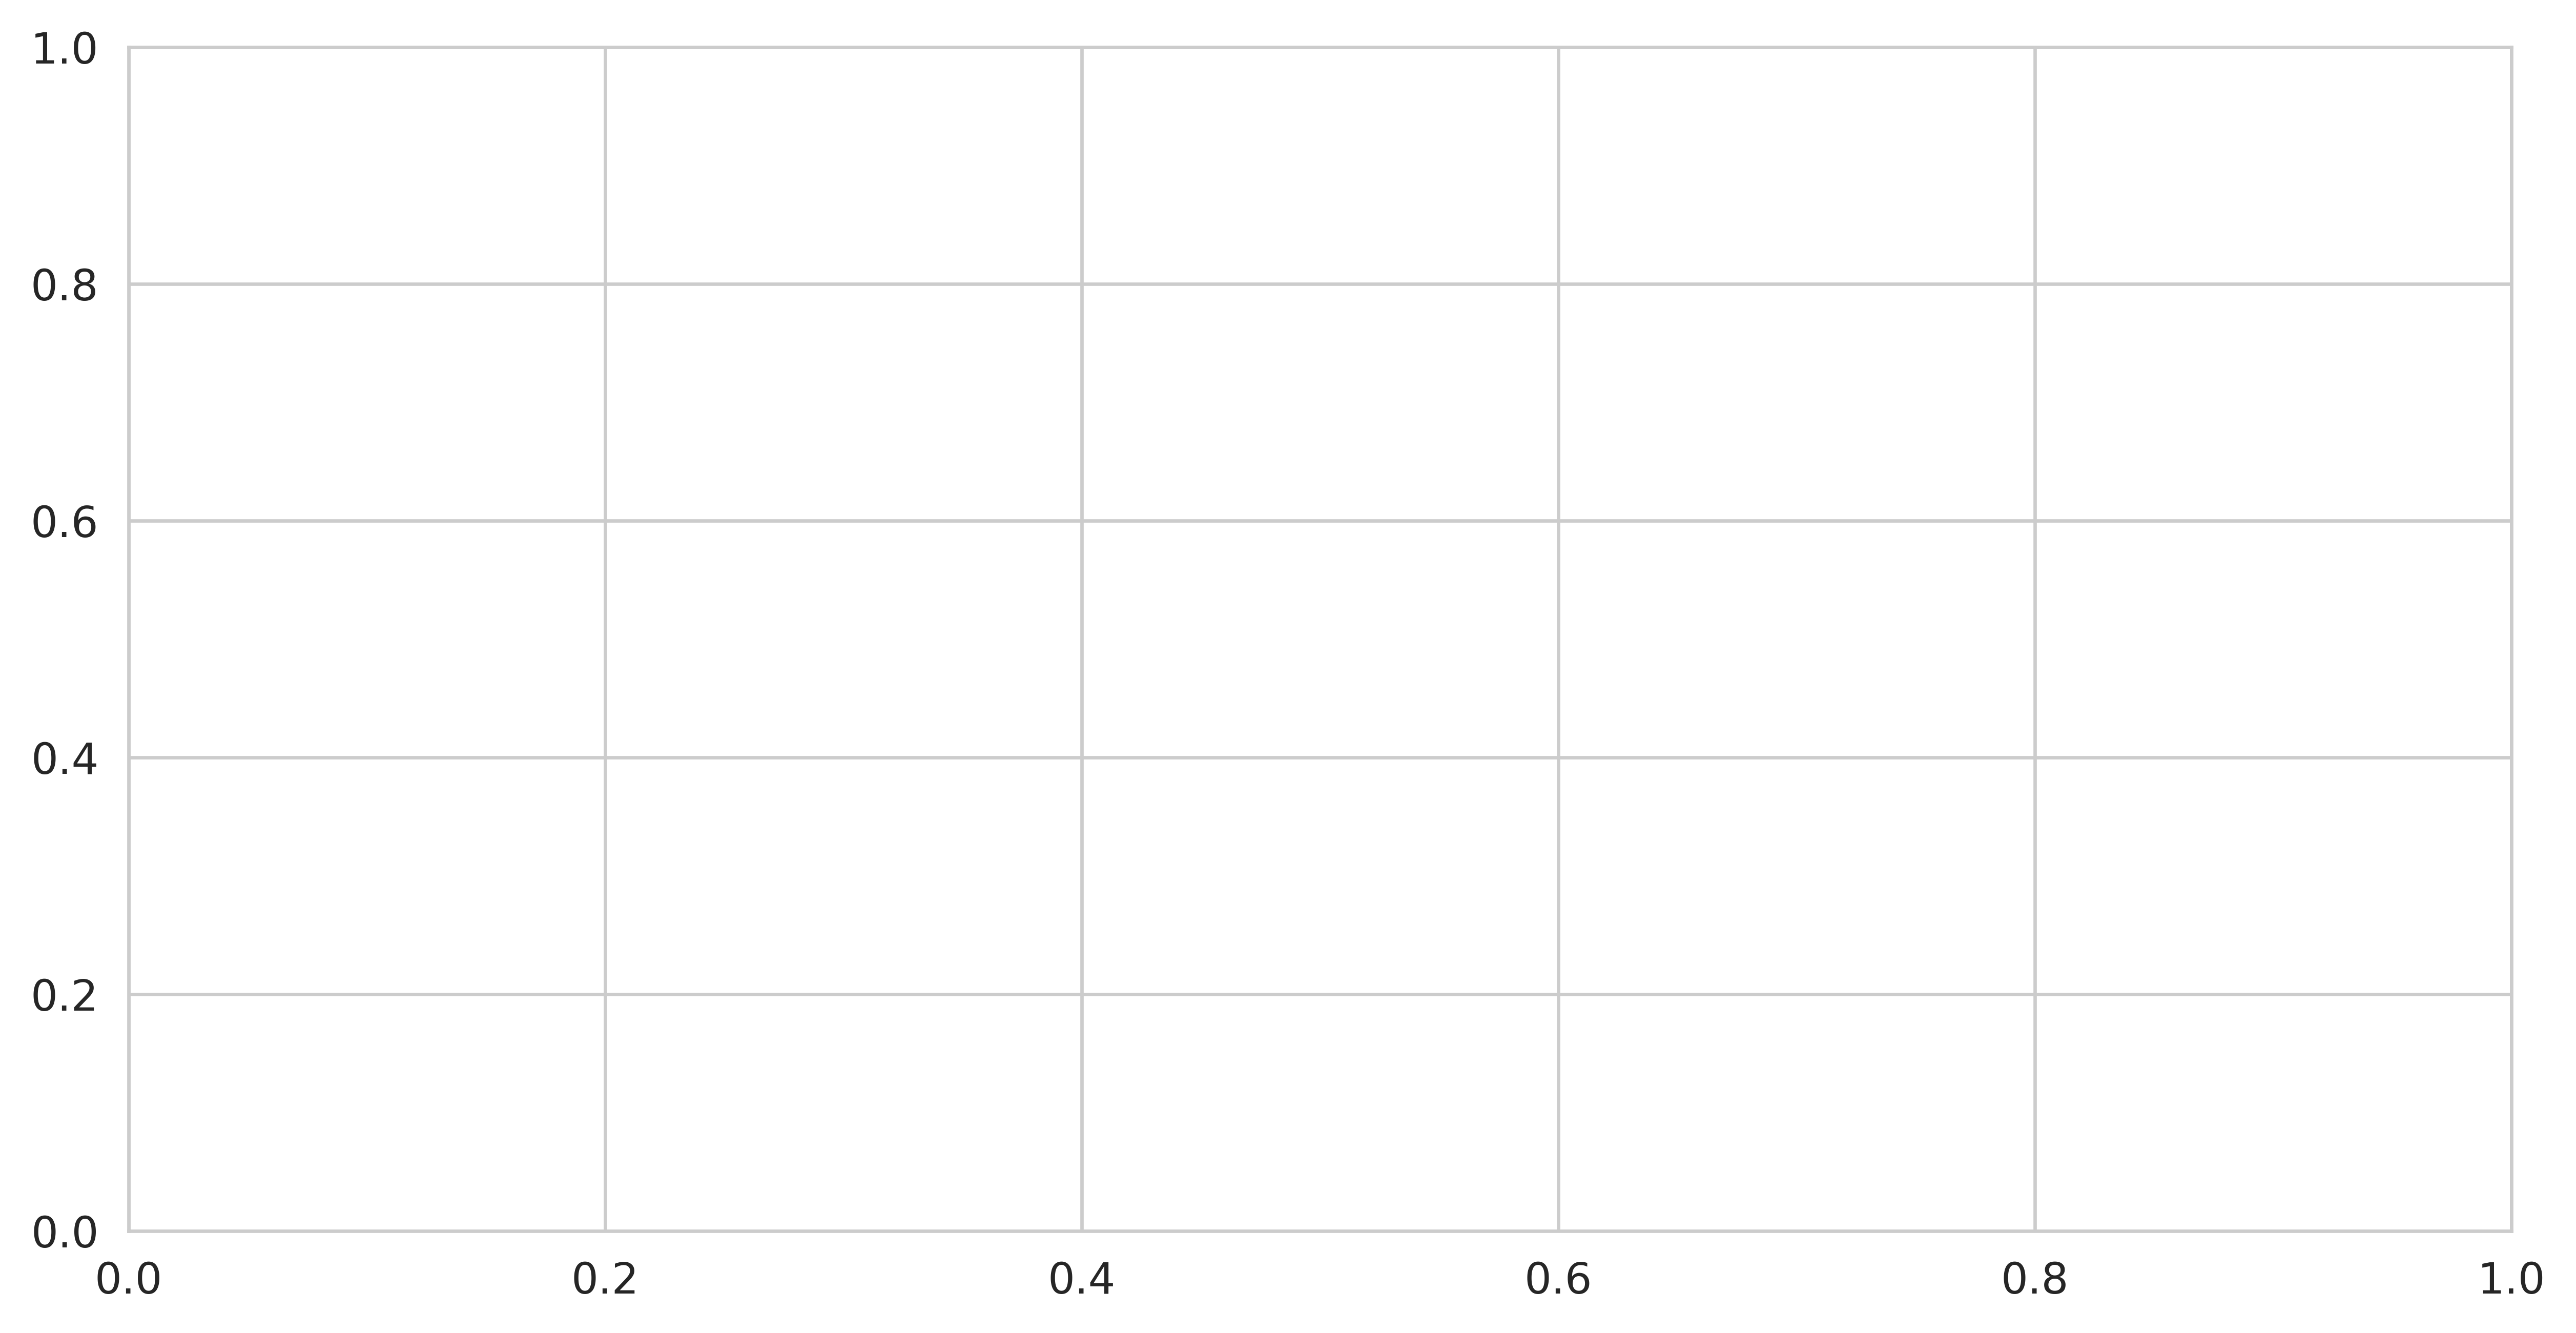

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
sns.set_palette("flare")

fig = plt.figure(dpi=600, figsize=(10, 5))
gs = GridSpec(1, 1)

ax1 = fig.add_subplot(gs[0, 0])

sns.histplot(ax1Main().dropna(), x= "log2FromMean_Nanopore", y="log2FromMean_TAB", cbar=True, cbar_kws={"shrink" : 0.5}, ax=ax1)
ax1.set_xlim(-5, 3)
ax1.set_ylim(-5, 3)
ax1.plot(np.arange(-5, 4, 1), np.arange(-5, 4, 1), linestyle="dashed", color="black", zorder=5, alpha=0.8)
ax1.set_xlabel("Nanopore")
ax1.set_ylabel("TAB")

rho = stats.spearmanr(ax1Main().dropna()["log2FromMean_Nanopore"], 
                      ax1Main().dropna()["log2FromMean_TAB"])

ax1.text(-4.5, 2.6, "Spearman \u03C1 = {rho:.2f}".format(rho=rho[0]))
ax1.text(-4.5, 2.2, "p-value = {rho:.1e}".format(rho=rho[1]))

fig.tight_layout()